<a href="https://colab.research.google.com/github/Altemir1/Machine_learning/blob/main/Fruit_Recognition_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading dataset

In [18]:
import numpy as np

train_data = np.load('training_data_strat.npz')
X_train = train_data['X_train']
y_train = train_data['y_train']

# Load testing data
test_data = np.load('testing_data_strat.npz')
X_test = test_data['X_test']
y_test = test_data['y_test']

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)


Createing dataloader

In [21]:
from torch.utils.data import Dataset, DataLoader
import torch

class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        # Inside __getitem__ of CustomDataset, adjusting for grayscale images to have a channel dimension
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.from_numpy(image).float()

        label_tensor = torch.tensor(label).long()

        return image, label_tensor

# Assuming X_train and y_train are loaded from your .npz file

train_dataset = CustomDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


test_dataset = CustomDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



Creating Simple CNN

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=30):  # Adjust num_classes based on your dataset
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 3 input channels for RGB
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 12 * 12, 512)  # This size might need adjustment
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.reshape(-1, 128 * 12 * 12)  # This size might need adjustment
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Assuming you're working with a device like "cuda" or "cpu"

model = SimpleCNN(num_classes=30)  # Adjust num_classes based on your dataset


Training loop

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of training epochs
epochs = 10

# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        # Forward pass
        images = images.permute(0, 3, 1, 2)

        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print average loss for the epoch
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.8f}')


Epoch [1/10], Loss: 0.07236979
Epoch [2/10], Loss: 0.02816301
Epoch [3/10], Loss: 0.00770335
Epoch [4/10], Loss: 0.02370110
Epoch [5/10], Loss: 0.01777137
Epoch [6/10], Loss: 0.02156656
Epoch [7/10], Loss: 0.05349684
Epoch [8/10], Loss: 0.01904697
Epoch [9/10], Loss: 0.00449112
Epoch [10/10], Loss: 0.02338398


Evaluation process

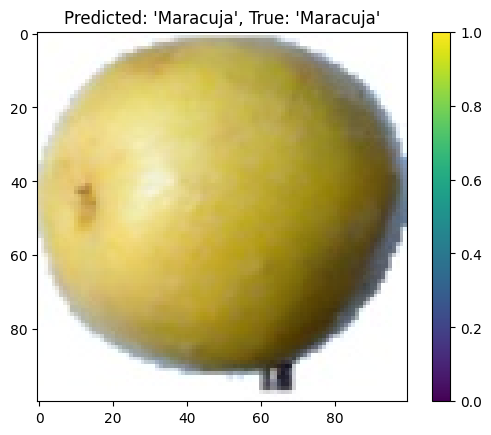

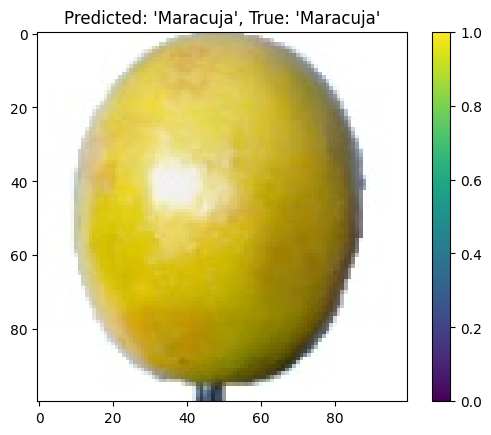

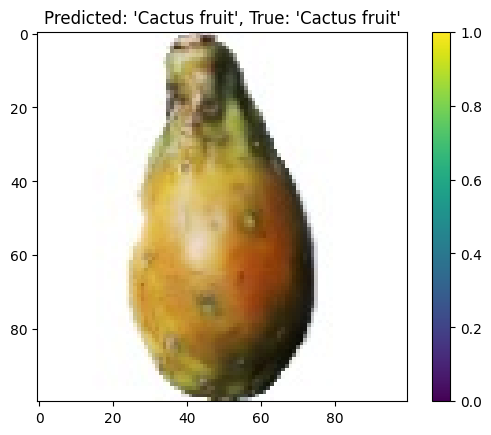

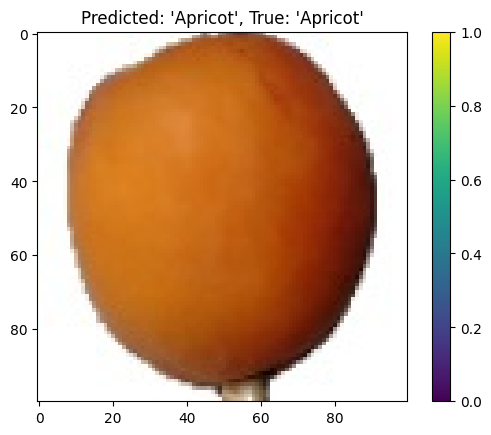

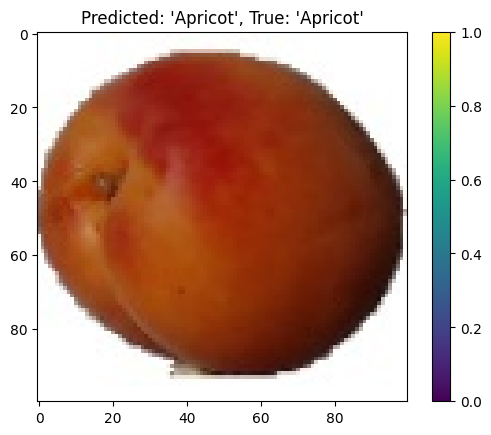

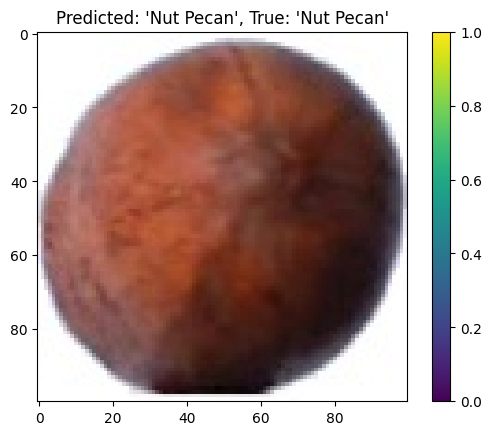

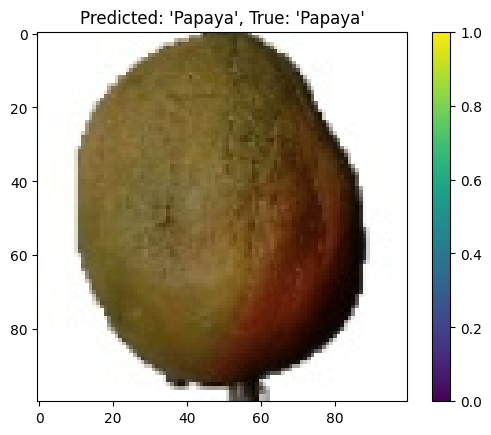

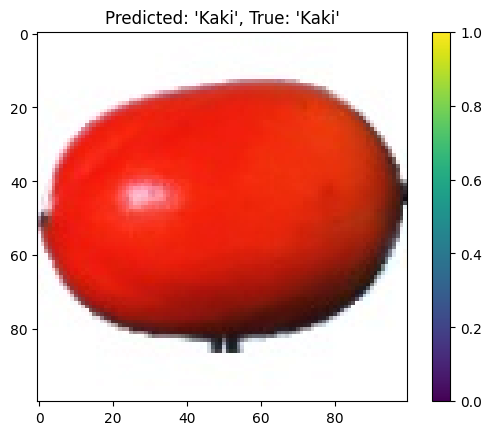

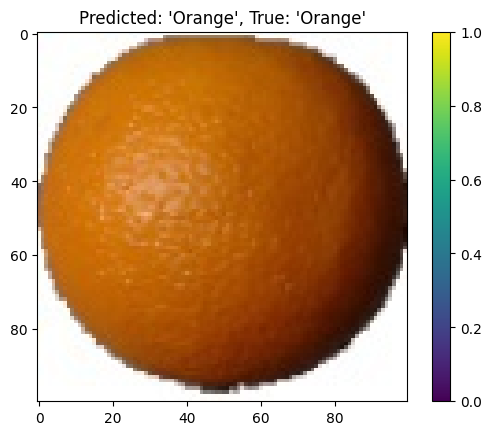

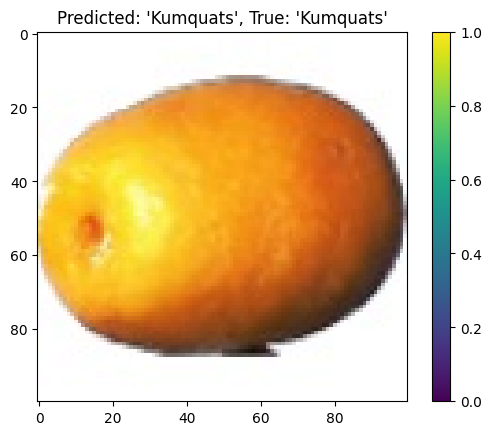

Accuracy of the model on the test images: 100.00%


In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure the function converts tensor to image correctly based on your data
def tensor_to_image(tensor):
    # Permute the tensor from (channels, height, width) to (height, width, channels)
    tensor = tensor.permute(1, 2, 0)
    # Convert to numpy array
    return tensor.detach().cpu().numpy()


model.eval()  # Set the model to evaluation mode
displayed_images = 0  # Counter for displayed images
correct = 0  # Counter for correct predictions
total = 0  # Counter for total images processed
num_images_to_display = 10

with torch.no_grad():
    for images, labels in test_loader:
        images = images.permute(0, 3, 1, 2)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Update total and correct counters
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for j in range(images.size(0)):
            if displayed_images >= num_images_to_display:
                break  # Exit the loop after displaying the desired number of images

            # Display the image
            image_np = tensor_to_image(images[j])
            # Normalize the pixel values to [0,1] if they aren't already
            image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
            plt.imshow(image_np)
            plt.colorbar()
            # Decode labels to get the string representation
            predicted_label = label_encoder.inverse_transform([predicted[j].item()])[0]
            true_label = label_encoder.inverse_transform([labels[j].item()])[0]
            plt.title(f"Predicted: '{predicted_label}', True: '{true_label}'")
            plt.show()

            displayed_images += 1

        if displayed_images >= num_images_to_display:
            break  # Exit the outer loop after displaying the desired number of images

# Calculate the accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the model on the test images: {accuracy:.2f}%')
